 # <center> SOROC </center> #

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import sys
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from HB_Plot import nf, fmt
import layers_calc_numba
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [2]:
# Some parameters
tau = ['50', '250', '500','750','1000', '2000', '3000', '10000']
Figletter = ['a) ', 'b) ', 'c) ', 'd) ', 'e) ', 'f) ', 'g) ', 'h) ', 'j) ']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis/Vary_N/'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'m/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs = np.array(runs)

## $ROC_{iso} (y,z)$ ##

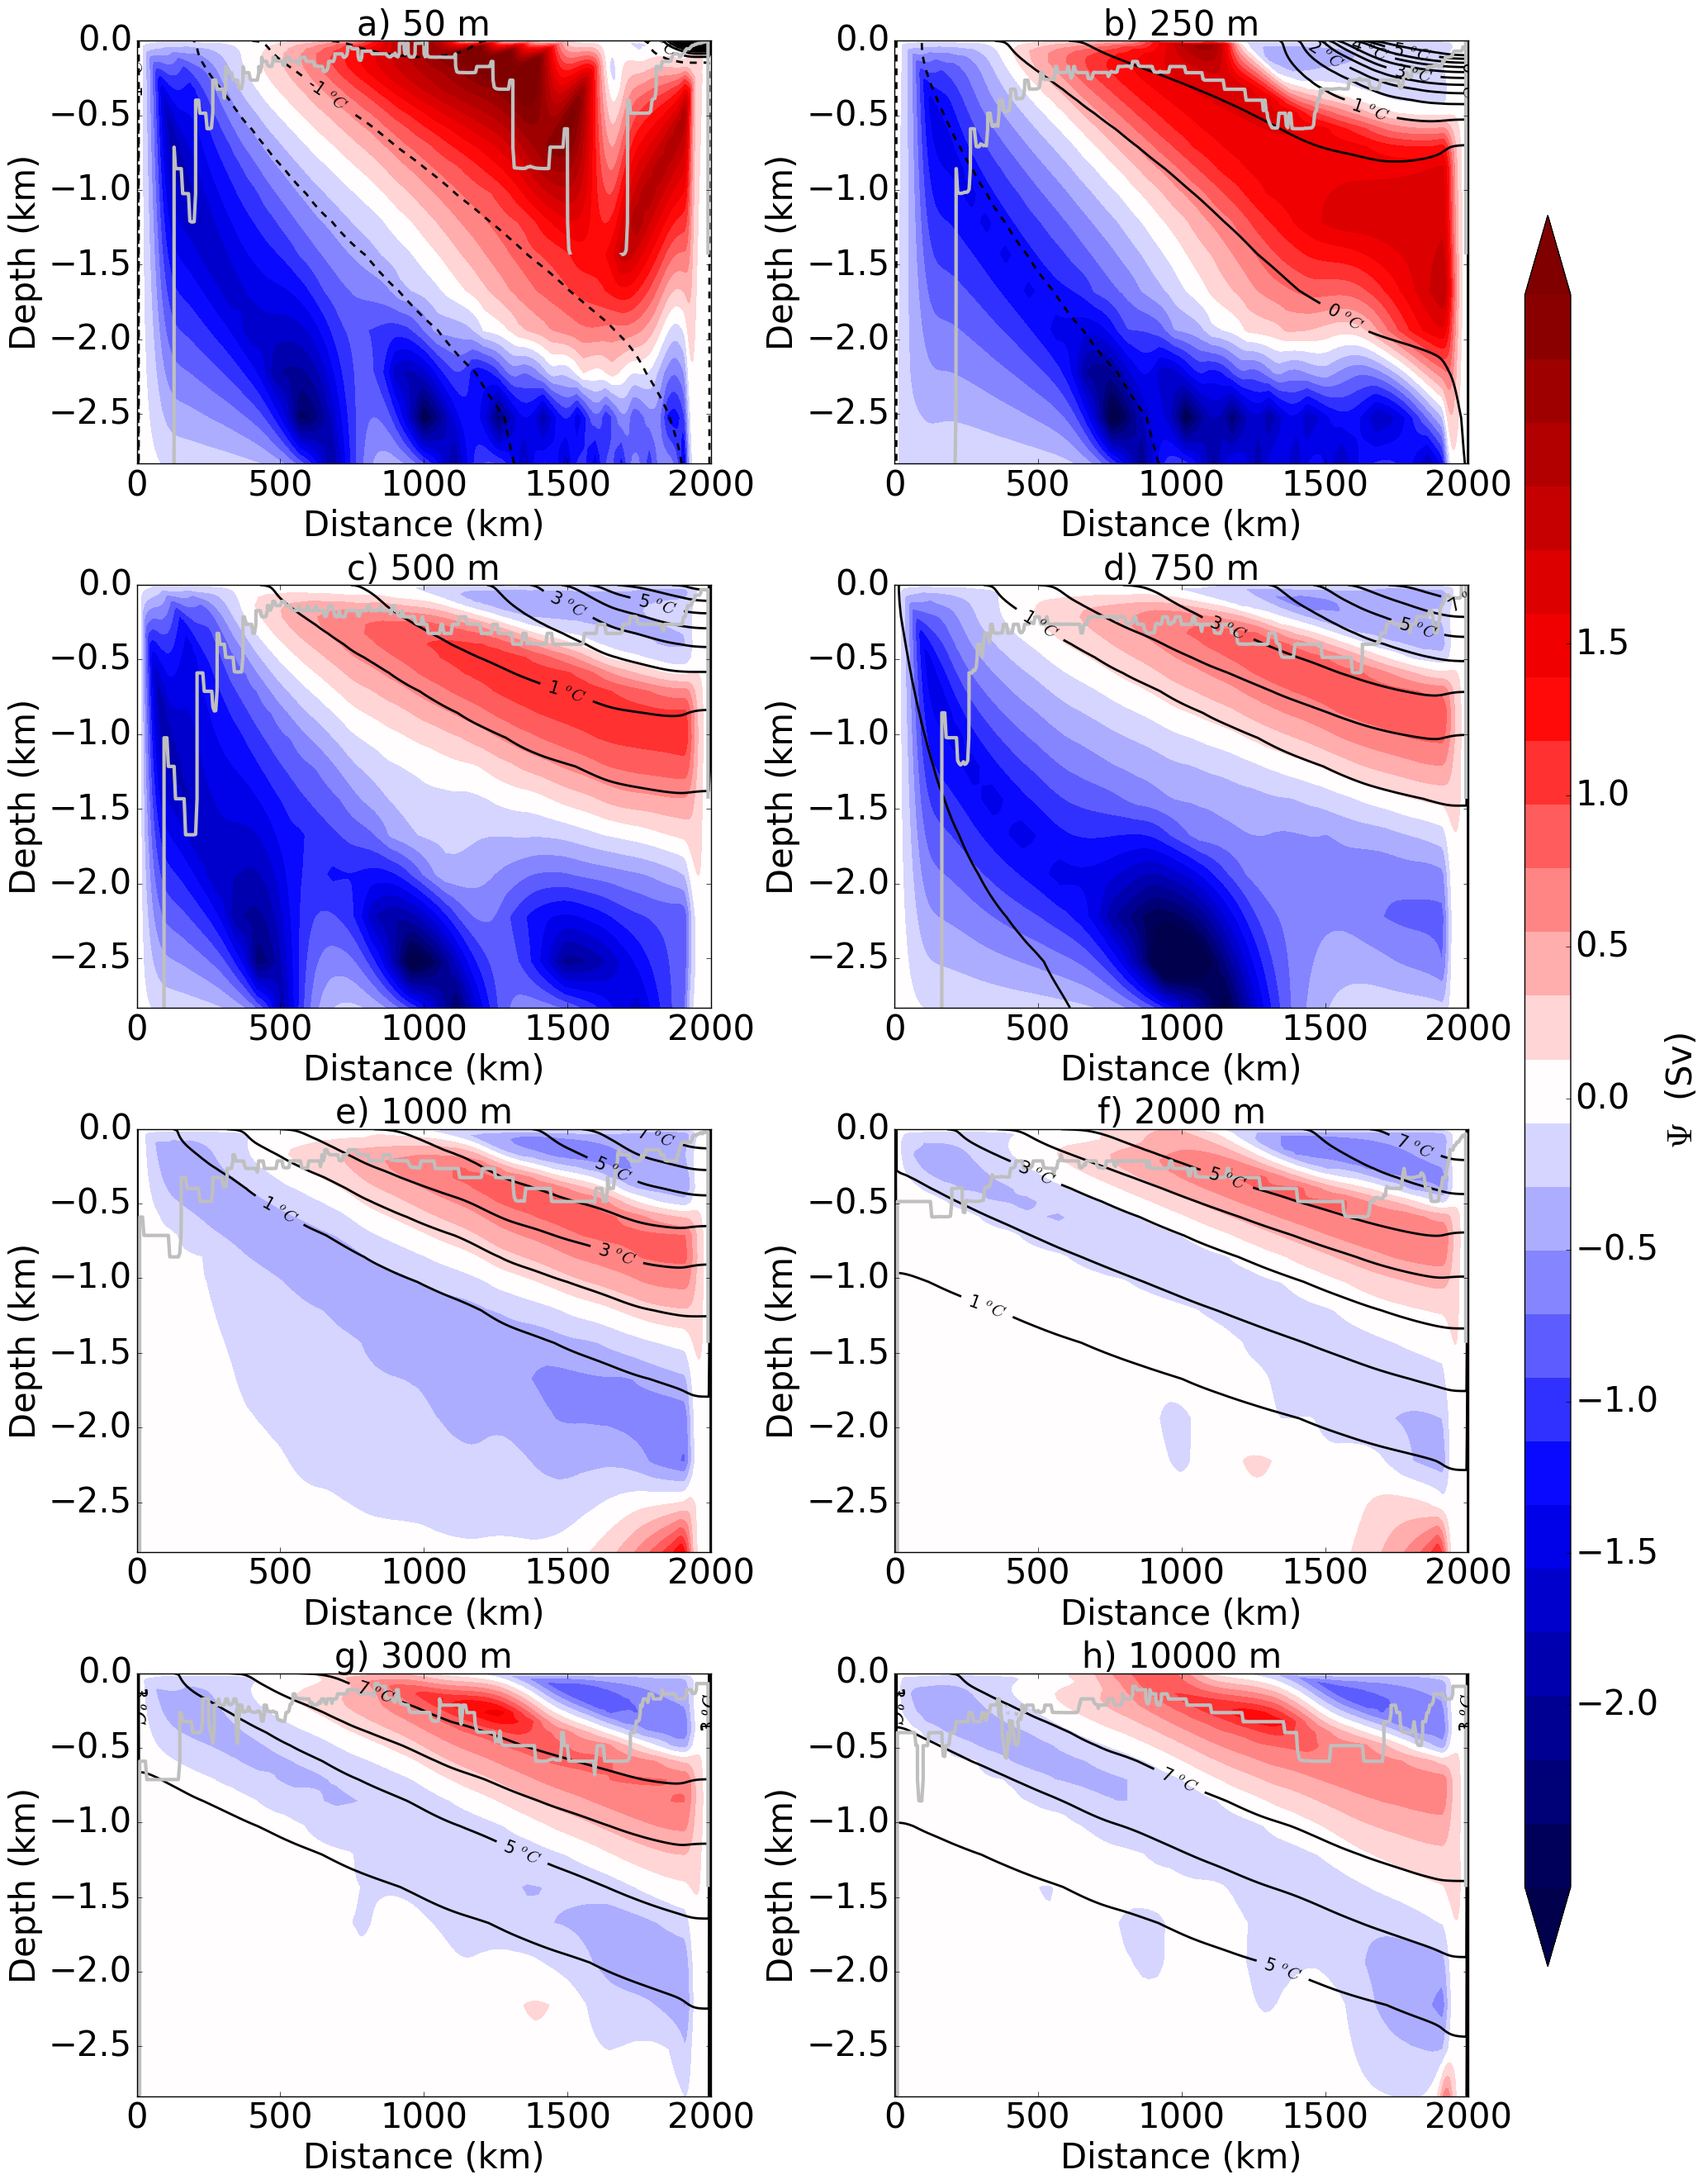

In [3]:
# Figure settings
fig = plt.figure(figsize=(18.5, 26.5))
Psi_levs = np.arange(-2.6, 2.7, .21)
Psi_ticks = np.arange(-2., 2., .5)
Q_levs = (np.arange(-2, 6, 0.5), np.arange(-2, 6, 0.5), np.arange(-1, 8, 1),
          np.arange(-1, 8, 1), np.arange(-1, 8, 1), np.arange(-1, 8, 1), np.arange(-1, 8, 1), 
          np.arange(-1, 8, 1))
# Loop through runs
ROC = []
layer_start = []
layer_fin = []
layer_med = []
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'m/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # Layers package variables
    Psi = c.get_psi_iso_z()/10**6
    g = layers_calc_numba.LayersComputer(c)
    PI = c.mnc('PSI.nc', "LaPs1TH").mean(axis=2)
    th = c.mnc('PSI.nc', "LaHs1TH").mean(axis=2)
    PIz = g.transform_g_to_z(PI, th)
    PIz[-5::, 50::] = np.nan
    Dmask = 1*Psi
    Dmask[Dmask<0] = 0
    Dmask[Dmask>0] =1
    Dmask[18::,:] = 1
    Dmask[:,0: -250] = 1 
    Psim = np.ma.masked_array(Psi, 1-Dmask)
    # Plot
    ax = fig.add_subplot(4, 2, i+1)
    # Make list of ROC / ROC0
    layer_start.append(c.get_zonal_avg('Tav.nc', 'THETA').min())
    layer_fin.append(c.get_zonal_avg('Tav.nc', 'THETA').max())
    layer_med.append(c.get_zonal_avg('Tav.nc', 'THETA').mean())
    if i == 0:
        Tref = c.get_zonal_avg('Tav.nc', 'THETA')[:,-10]
        Tsurf = c.get_zonal_avg('Tav.nc', 'THETA')[0,:]
        ROC0 = np.sum(abs(Psim))
    ROC.append((np.sum(abs(Psim))-ROC0)/ROC0)
    # Plot ROC
    p = ax.contourf(c.yc/1000, c.zc/1000, Psi, Psi_levs,
                    cmap=plt.cm.seismic, extend='both')
    # Add temp contours
    q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc', 'THETA'),
                   Q_levs[i], colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    # Add diabatic layer depth
    r = ax.contour(c.yg/1000, c.zc/1000, PIz, [0.99999999],
                   colors='0.75', linewidths=3)
    # Title
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' m', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
# Final adjustments and colourbar
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel(r'$\Psi$  (Sv)', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

## Layers ##

In [17]:
# Generate layers
# Select run
i = 2
# Tell me the run I've selected
print tau[i],'m'
# Parameters from output adjust to ensure all layers are fully captured
bot = math.floor(layer_start[i]) # Round down
top = math.ceil(layer_fin[i]) # Round up
med = np.round(np.round(layer_med[i],1))
# High resolution for the layers of interest!
layers = np.arange(med-1.0,med+1.0, 0.1)
# Fill in the layers from low temps to layers of interest
layers1 = np.linspace(bot,layers[0],12)
# Fill in the layers from layers of interest to the maximum temperature
layers2 = np.linspace(layers[-1],top,12)
# Concatonate 
layers_data = layers1[0:-1].tolist() + layers.tolist() + layers2[1::].tolist()
layers_data.append(top+0.2)
# Adjust for temperature skews
# If layers of interest encompass the bottom value
if med-1 <= bot: 
    # Fill in only the layers of interest to the maximum temperature
    layers2 = np.linspace(layers[-1],top,23)
    layers_data = layers.tolist() + layers2[1::].tolist() 
    layers_data.append(top+0.2)
# If layers of interest are far hotter than the bottom value
elif abs(bot-(med-1))<2.4 :
    # Take less lower values
    layers1 = np.linspace(bot,layers[0],10)
    # And more higher values
    layers2 = np.linspace(layers[-1],top,14)
    layers_data = layers1[0:-1].tolist() + layers.tolist() + layers2[1::].tolist() 
# Neaten it up
layers_data_final = np.round(layers_data,2)
layers_data.append(top+0.2)
# Commma separate it.
print ",".join(map(str,layers_data_final))

500 m
-1.0,-0.89,-0.78,-0.67,-0.56,-0.44,-0.33,-0.22,-0.11,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.37,2.84,3.31,3.78,4.25,4.72,5.18,5.65,6.12,6.59,7.06,7.53,8.0


## Change in ROC with increasing N ##

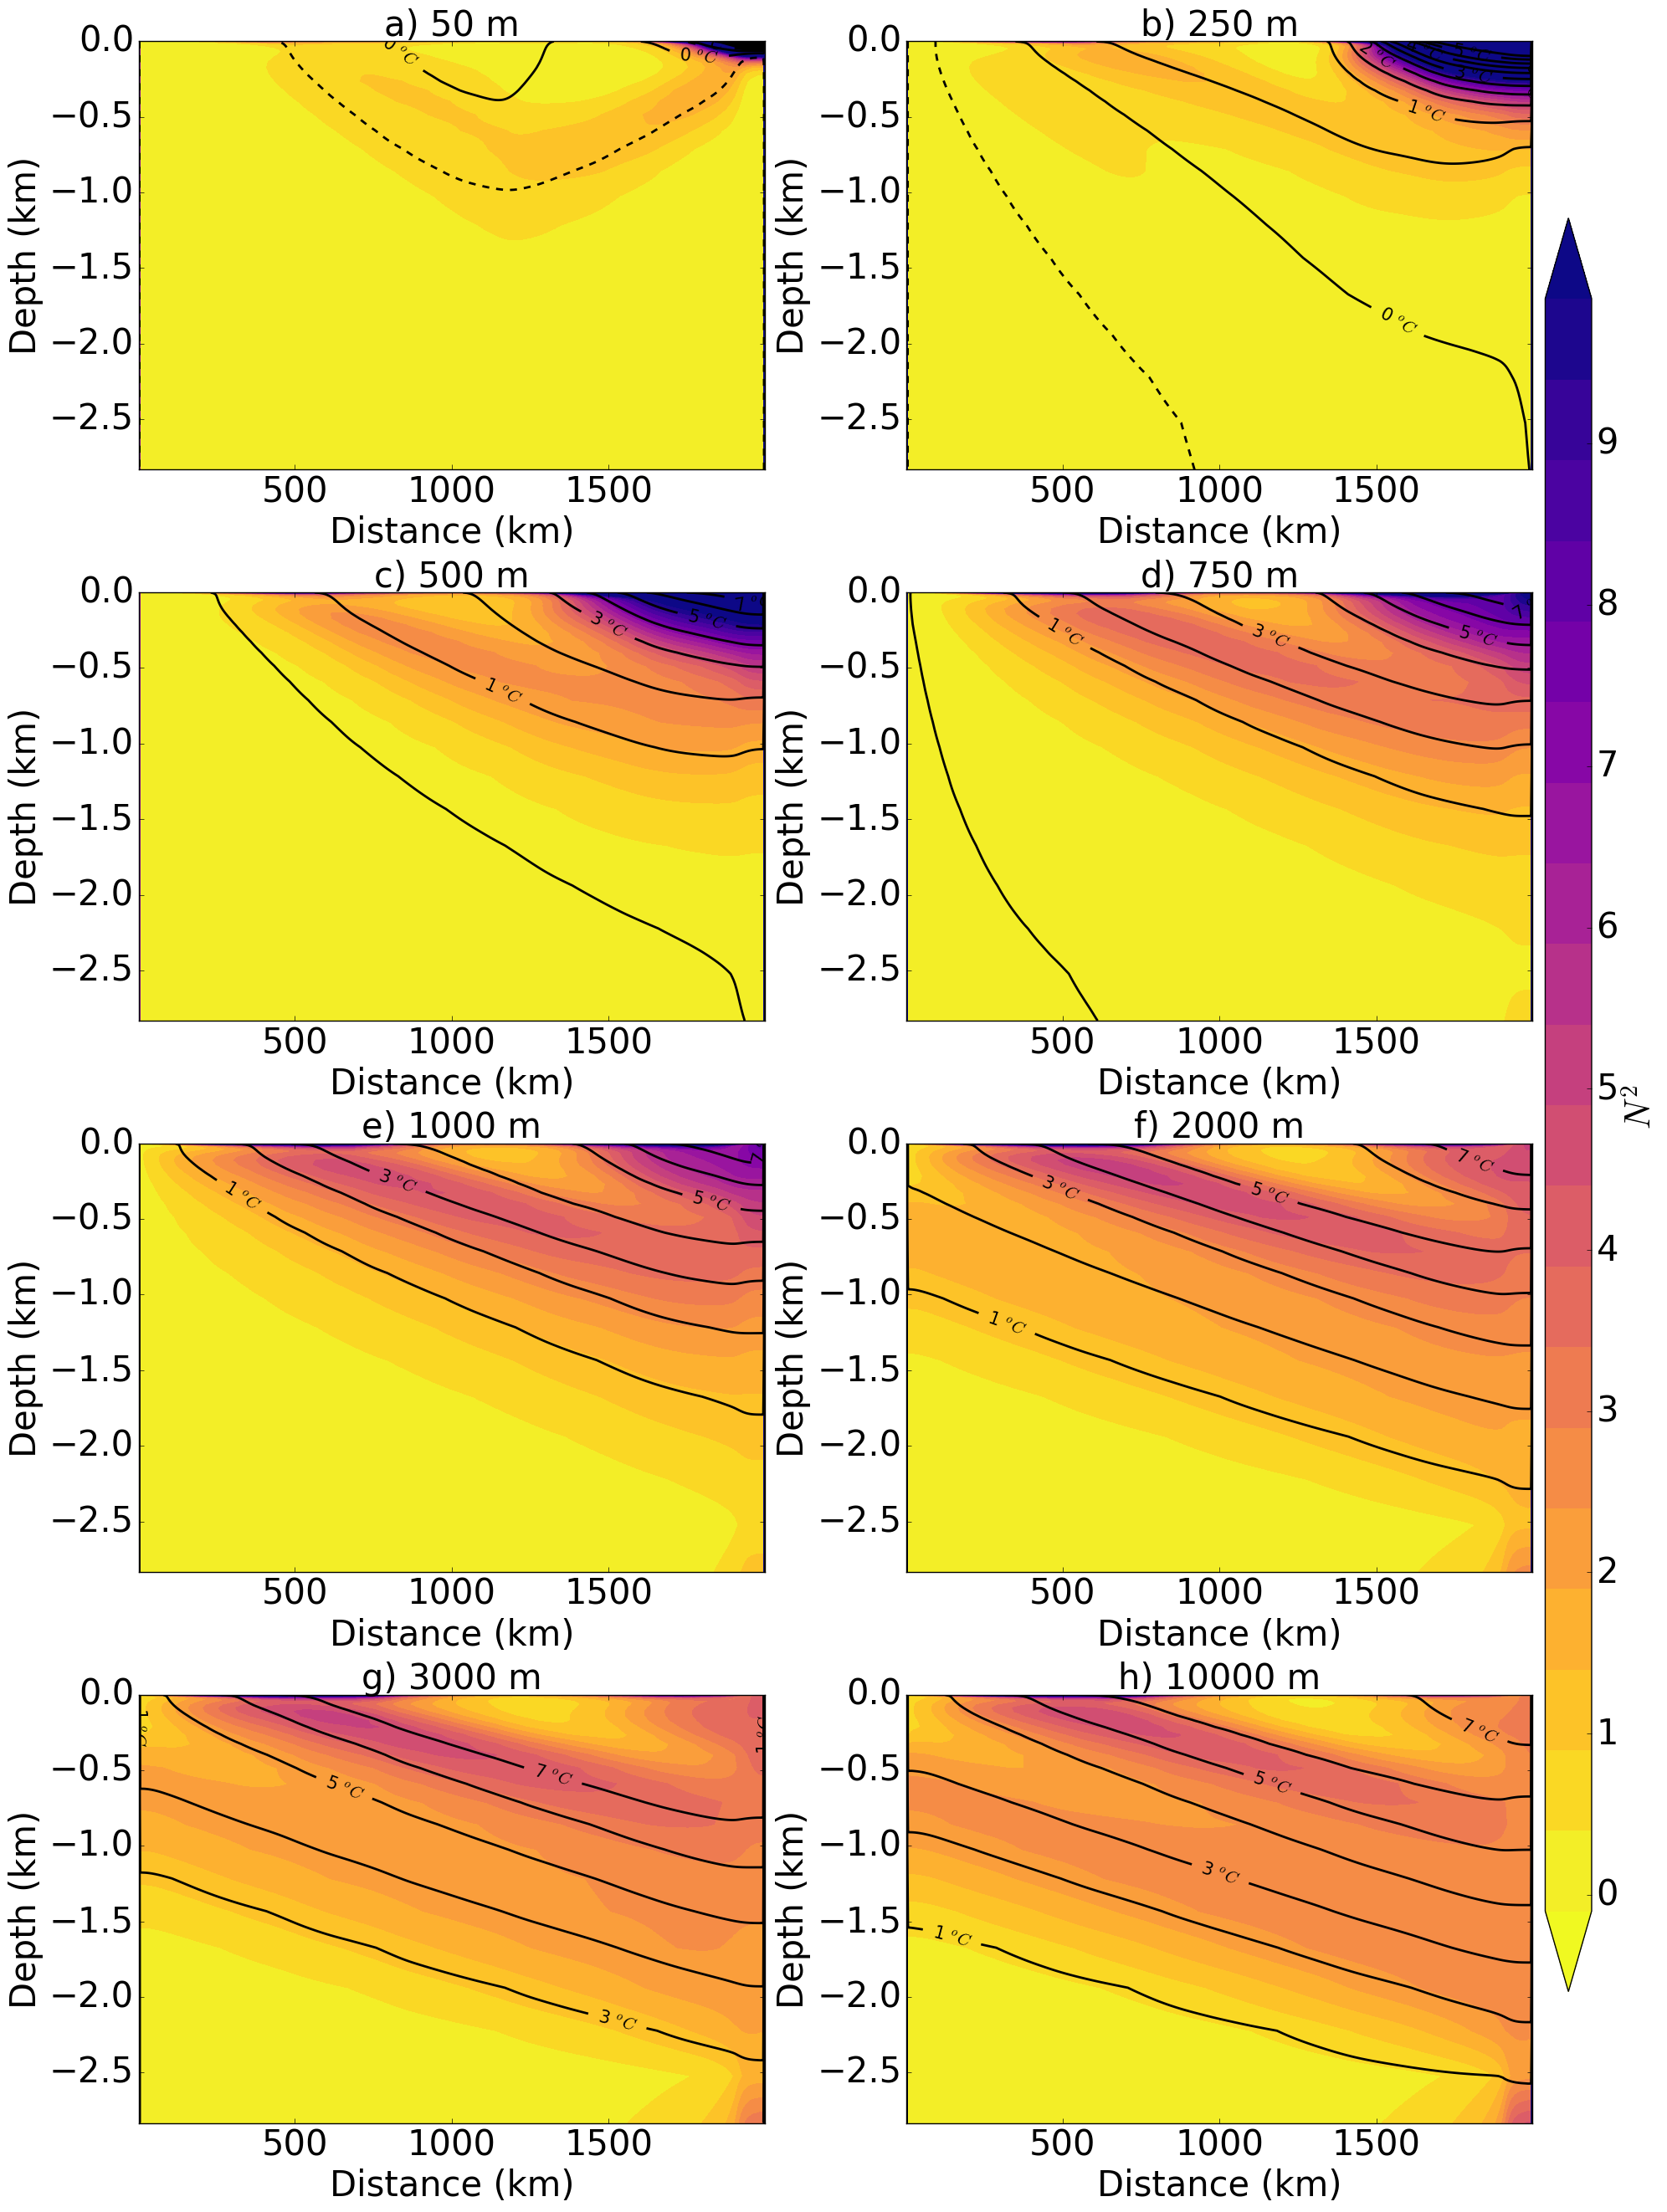

In [7]:
# Figure settings
fig = plt.figure(figsize=(18.5, 26.5))
Psi_levs = np.arange(-.1, 10, .5)
Psi_ticks =np.arange(0, 10, 1)
Q_levs = (np.arange(-2, 6, 0.5), np.arange(-2, 6, 0.5), np.arange(-1, 8, 1),
          np.arange(-1, 8, 1), np.arange(-1, 8, 1), np.arange(-1, 8, 1), np.arange(-1, 8, 1), 
          np.arange(-1, 8, 1))
# Loop through runs
N2t = []
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'m/'
    c = utils.ChannelSetup(output_dir=str(fname))
    CellVol = 5000*np.tile(c.dzf,(c.Ny,1)).T
    #  N2
    N2 = c.get_N2()
    # Plot
    ax = fig.add_subplot(4, 2, i+1)
    # Make list of ROC / ROC0
    if i == 0:
        N20 = np.sum(abs(N2*CellVol))/(3000*c.Ly)
    N2t.append(((np.sum(abs(N2*CellVol)))/(3000*c.Ly)-N20)/N20)
    # Plot ROC
    p = ax.contourf(c.yc/1000, c.zc/1000, N2*10**6, Psi_levs,
                    cmap=plt.cm.plasma_r, extend='both')
    # Add temp contours
    q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc', 'THETA'),
                   Q_levs[i], colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    
    # Title
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' m', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
# Final adjustments and colourbar
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel(r'$N^2$ ', fontsize=30, )
cbar.ax.tick_params(labelsize=30)

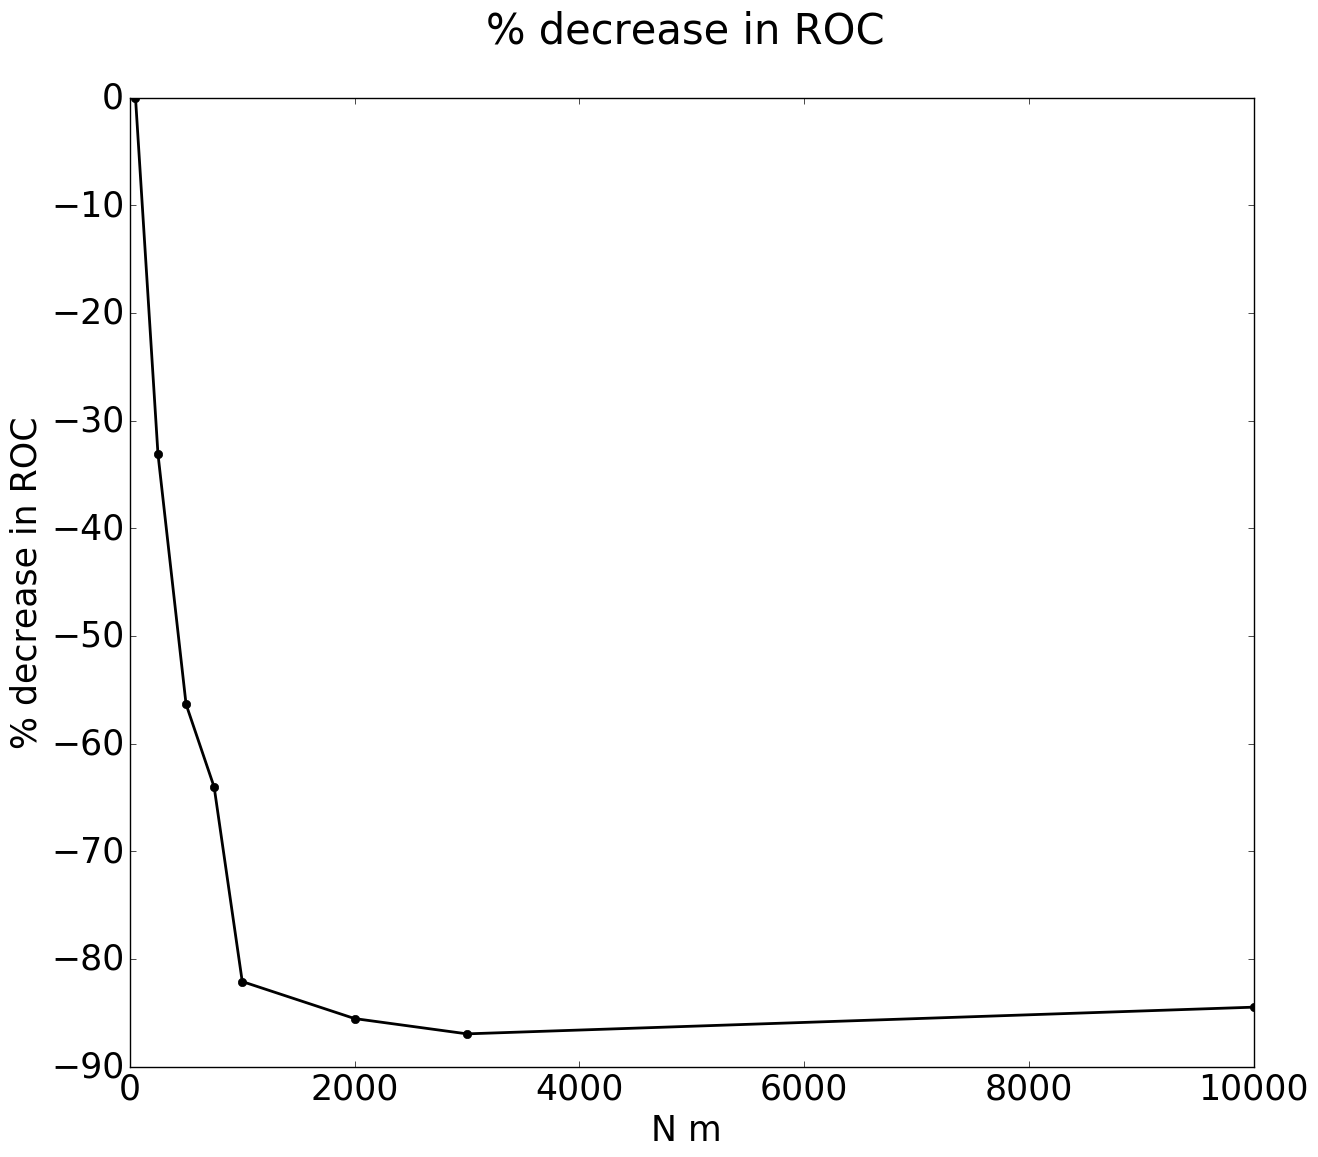

In [137]:
fig = plt.figure(figsize=(14.5, 12.5))
Tau = [50, 250, 500, 750, 1000, 2000, 3000, 10000]
p = plt.plot(tau, np.array(ROC)*100,'-ko', linewidth=2)
#plt.ylim(-100,5)
#plt.xscale("log",base=np.e)
#plt.xlim(0,2*10**4)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('N m ', fontsize=25)
plt.ylabel('% decrease in ROC', fontsize=25)
plt.title("% decrease in ROC \n",fontsize=30)


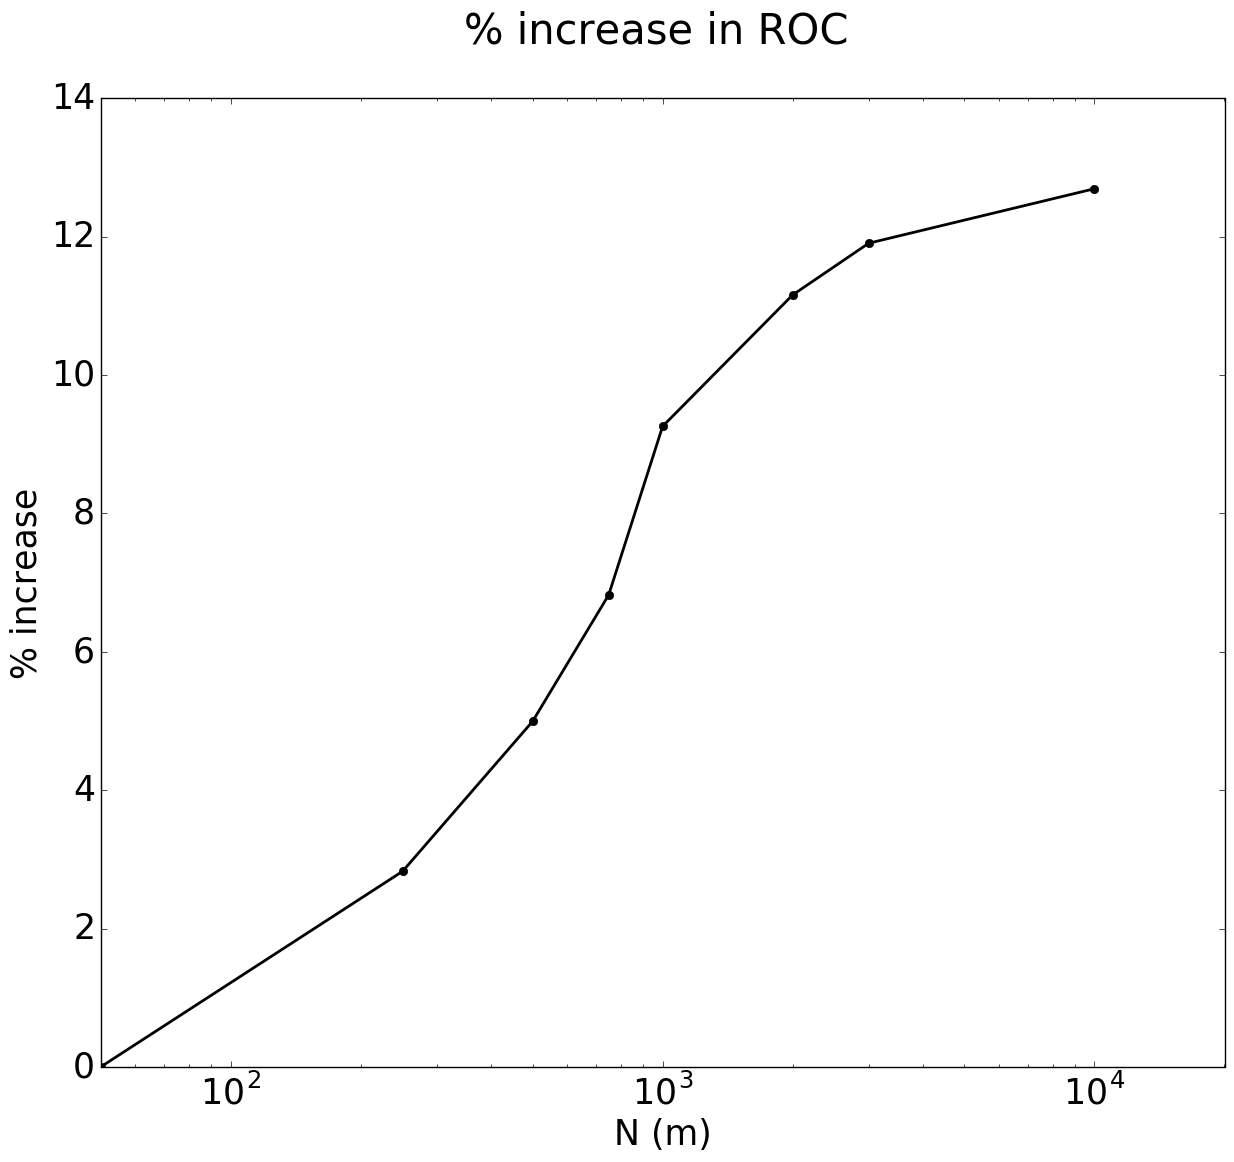

In [138]:
fig = plt.figure(figsize=(14.5, 12.5))
Tau = [50, 250, 500, 750, 1000, 2000, 3000, 10000]
p = plt.plot(Tau, np.array(N2t)*100,'-ko', linewidth=2)
#plt.ylim(0,1)
plt.xscale("log")
plt.xlim(0,2*10**4)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('N (m)', fontsize=25)
plt.ylabel('% increase', fontsize=25)
plt.title("% increase in ROC \n",fontsize=30)


## Figure for paper ##

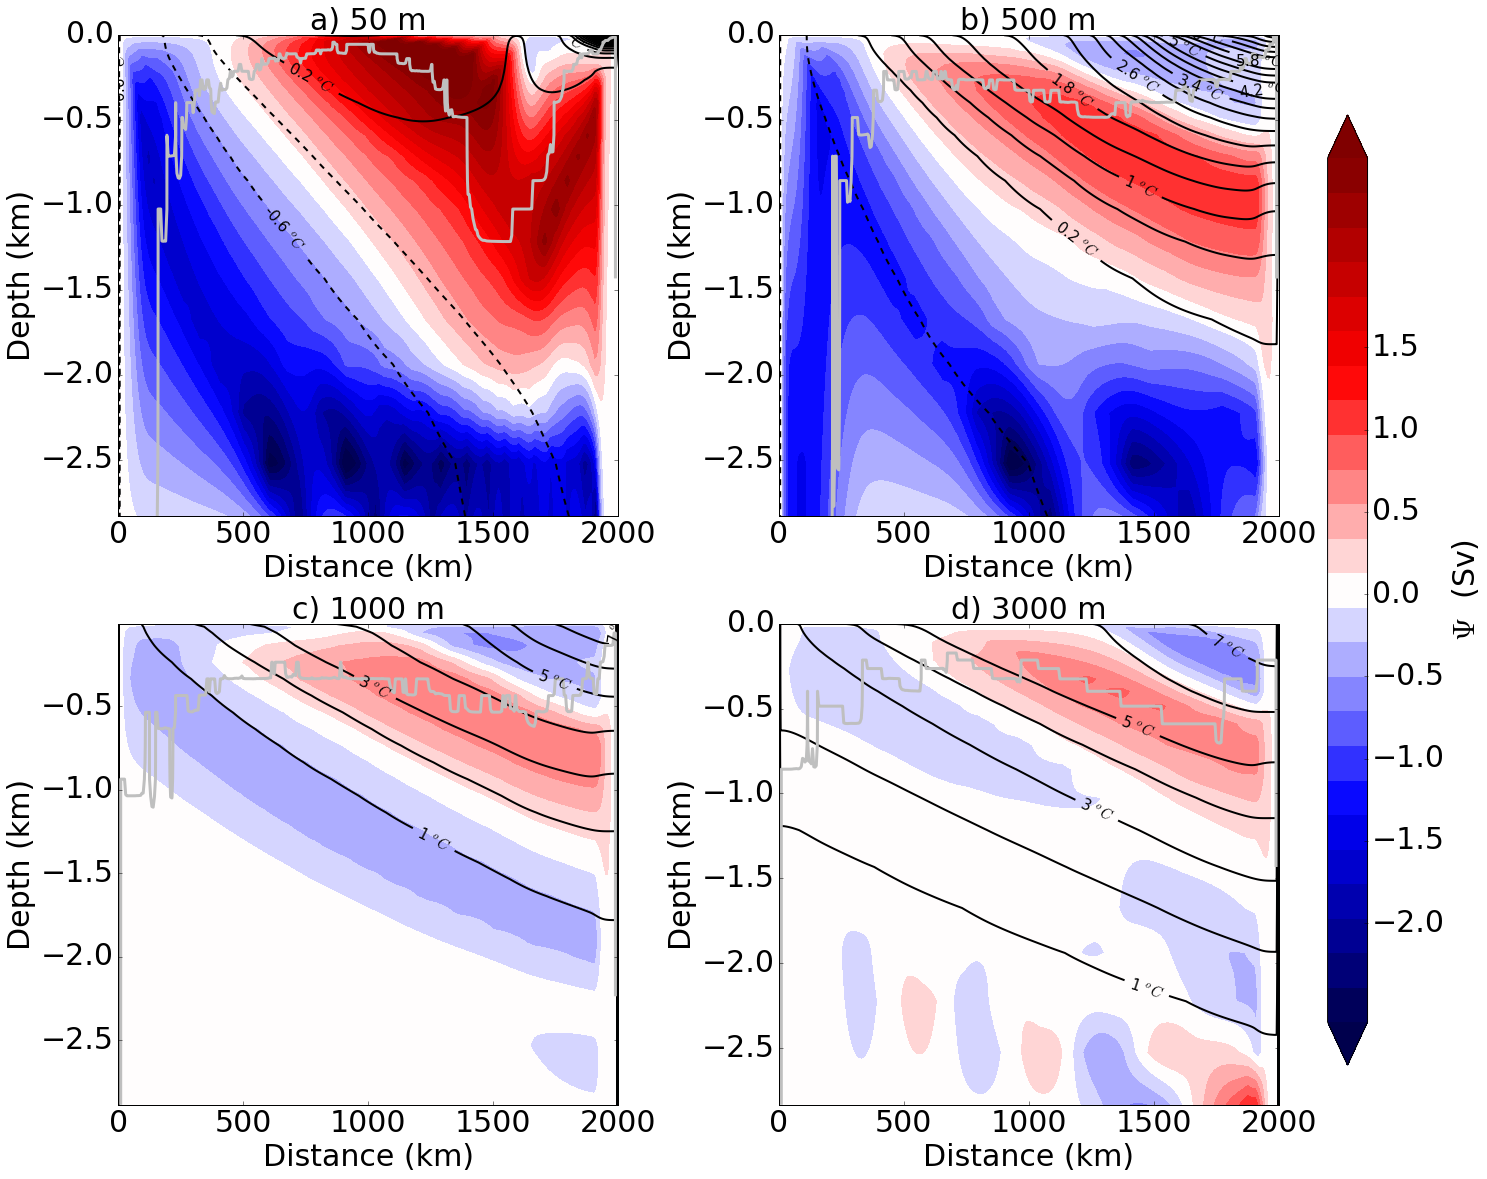

In [25]:
# Figure settings
fig = plt.figure(figsize=(18.5, 16.5))
Psi_levs = np.arange(-2.6, 2.7, .21)
Psi_ticks = np.arange(-2., 2., .5)
Q_levs = (np.arange(-0.6, 8, 0.4), np.arange(-.6, 8, 0.4), np.arange(-1, 8, 1),
          np.arange(-1, 8, 1), np.arange(-1, 10, 2), np.arange(-1, 10, 2))
# Loop through runs
ROC = []
# Pick 4 that illustrate well
tau = ['50', '500', '1000','3000']
for i in range(4):
    fname = x+'/'+str(tau[Runs[i]])+'m/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # Layers package variables
    Psi = c.get_psi_iso_z()/10**6
    g = layers_calc_numba.LayersComputer(c)
    PI = c.mnc('PSI.nc', "LaPs1TH").mean(axis=2)
    th = c.mnc('PSI.nc', "LaHs1TH").mean(axis=2)
    PIz = g.transform_g_to_z(PI, th)
    PIz[-5::, 50::] = np.nan
    # Plot
    ax = fig.add_subplot(2, 2, i+1)
    # Make list of ROC / ROC0

    if i == 0:
        ROC0 = np.sum(abs(ROC))
    ROCT.append((np.sum(abs(ROC))-ROC0)/ROC0)
    # Plot ROC
    p = ax.contourf(c.yc/1000, c.zc/1000, Psi, Psi_levs,
                    cmap=plt.cm.seismic, extend='both')
    # Add temp contours
    q = ax.contour(c.yc/1000, c.zc/1000, c.get_zonal_avg('Tav.nc', 'THETA'),
                   Q_levs[i], colors='k', linewidths=2)
    q.levels = [nf(val) for val in q.levels]
    plt.clabel(q, q.levels[::2], inline=1, fmt=fmt, fontsize=15)
    # Add diabatic layer depth
    r = ax.contour(c.yg/1000, c.zc/1000, PIz, [0.99999999],
                   colors='0.75', linewidths=3)
    # Title
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+' m', fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel('Depth (km)', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
# Final adjustments and colourbar
plt.tight_layout()
cax = fig.add_axes([1, 0.1, 0.03, 0.8])
cbar = fig.colorbar(p, cax=cax, ticks=Psi_ticks)
cbar.ax.set_ylabel(r'$\Psi$  (Sv)', fontsize=30, )
cbar.ax.tick_params(labelsize=30)